# Step 0: Setup Dependencies

In [3]:
%pip install tableone

  Using cached tableone-0.8.0-py3-none-any.whl (33 kB)


In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tableone
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import warnings
# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Step 1: Read in data

In [36]:
complete_df = pd.read_csv('complete_df.csv')
complete_df_filtered = pd.read_csv('complete_df_filtered.csv')
complete_df_dead = pd.read_csv('complete_df_dead.csv')

In [37]:
X_cols = ['anchor_age', 'gender', 'anchor_year',
       'sepsis3', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

In [38]:
X_full = complete_df_filtered[X_cols+['los']].copy()
X_full.fillna(X_full.mean(), inplace=True) #fill missing values with mean of each column

In [39]:
X_full.columns

Index(['anchor_age', 'gender', 'anchor_year', 'sepsis3', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness', 'los'],
      dtype='object')

# Step 2: Predictive Model using Linear Regression

In [40]:
# check for variable correlation & feature selection

#find design matrix for linear regression model using 'los' as response variable
y_vif, X_vif = dmatrices('los ~ anchor_age+gender+anchor_year+sepsis3+procedure_freq+icu_stay_num+admission_num+in2first_days+first2out_days+in2last_days+last2out_days+first2last_days+death+initial_vasopressor_needed_within_24hr+initial_ventilation_within_6hr+initial_fio2_above_60_within_6hr+initial_sodium+initial_wbc+initial_creatinine+initial_ph+initial_lactate+initial_baseexcess+initial_glucose+initial_crp+off_vasopressors+last_fio2_above_60+off_ventilation+last_ph+last_lactate+last_baseexcess+last_hemoglobin+last_creatinine+last_sodium+last_glucose+last_wbc+last_crp+readiness', data=X_full, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [41]:
# any vif value > 5 suggest high correlation between variabels and therefore will be dropped from analysis
vif

,VIF,variable
0,0.000000,Intercept
1,1.283287,anchor_age
2,1.094471,gender
3,1.087082,anchor_year
4,0.000000,sepsis3
5,3.365084,procedure_freq
6,1.129171,icu_stay_num
7,1.100463,admission_num
8,388.661720,in2first_days
9,1375.945844,first2out_days


In [42]:
# recheck vif to confirm there is no longer significant multicolinearity between predictors
y_vif2, X_vif2 = dmatrices('los ~ anchor_age+gender+anchor_year+sepsis3+procedure_freq+icu_stay_num+admission_num+in2first_days+death+initial_vasopressor_needed_within_24hr+initial_ventilation_within_6hr+initial_fio2_above_60_within_6hr+initial_sodium+initial_wbc+initial_creatinine+initial_ph+initial_lactate+initial_baseexcess+initial_glucose+initial_crp+off_vasopressors+last_fio2_above_60+off_ventilation+last_ph+last_lactate+last_baseexcess+last_hemoglobin+last_creatinine+last_sodium+last_glucose+last_wbc+last_crp+readiness', data=X_full, return_type='dataframe')
vif2 = pd.DataFrame()
vif2['VIF'] = [variance_inflation_factor(X_vif2.values, i) for i in range(X_vif2.shape[1])]
vif2['variable'] = X_vif2.columns
assert (vif2.VIF < 5).all(), "Review - there are still VIF values greater than 5"

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [43]:
# Filter the DataFrame to get variable names with VIF less than 5
selected_variables = vif2.loc[vif2['VIF'] < 5, 'variable'].tolist()
selected_variables.remove('Intercept')
selected_variables

['anchor_age',
 'gender',
 'anchor_year',
 'sepsis3',
 'procedure_freq',
 'icu_stay_num',
 'admission_num',
 'in2first_days',
 'death',
 'initial_vasopressor_needed_within_24hr',
 'initial_ventilation_within_6hr',
 'initial_fio2_above_60_within_6hr',
 'initial_sodium',
 'initial_wbc',
 'initial_creatinine',
 'initial_ph',
 'initial_lactate',
 'initial_baseexcess',
 'initial_glucose',
 'initial_crp',
 'off_vasopressors',
 'last_fio2_above_60',
 'off_ventilation',
 'last_ph',
 'last_lactate',
 'last_baseexcess',
 'last_hemoglobin',
 'last_creatinine',
 'last_sodium',
 'last_glucose',
 'last_wbc',
 'last_crp',
 'readiness']

In [67]:
# split train & test
X = X_full[selected_variables]
y = X_full['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=8)

In [68]:
X.columns

Index(['anchor_age', 'gender', 'anchor_year', 'sepsis3', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness'],
      dtype='object')

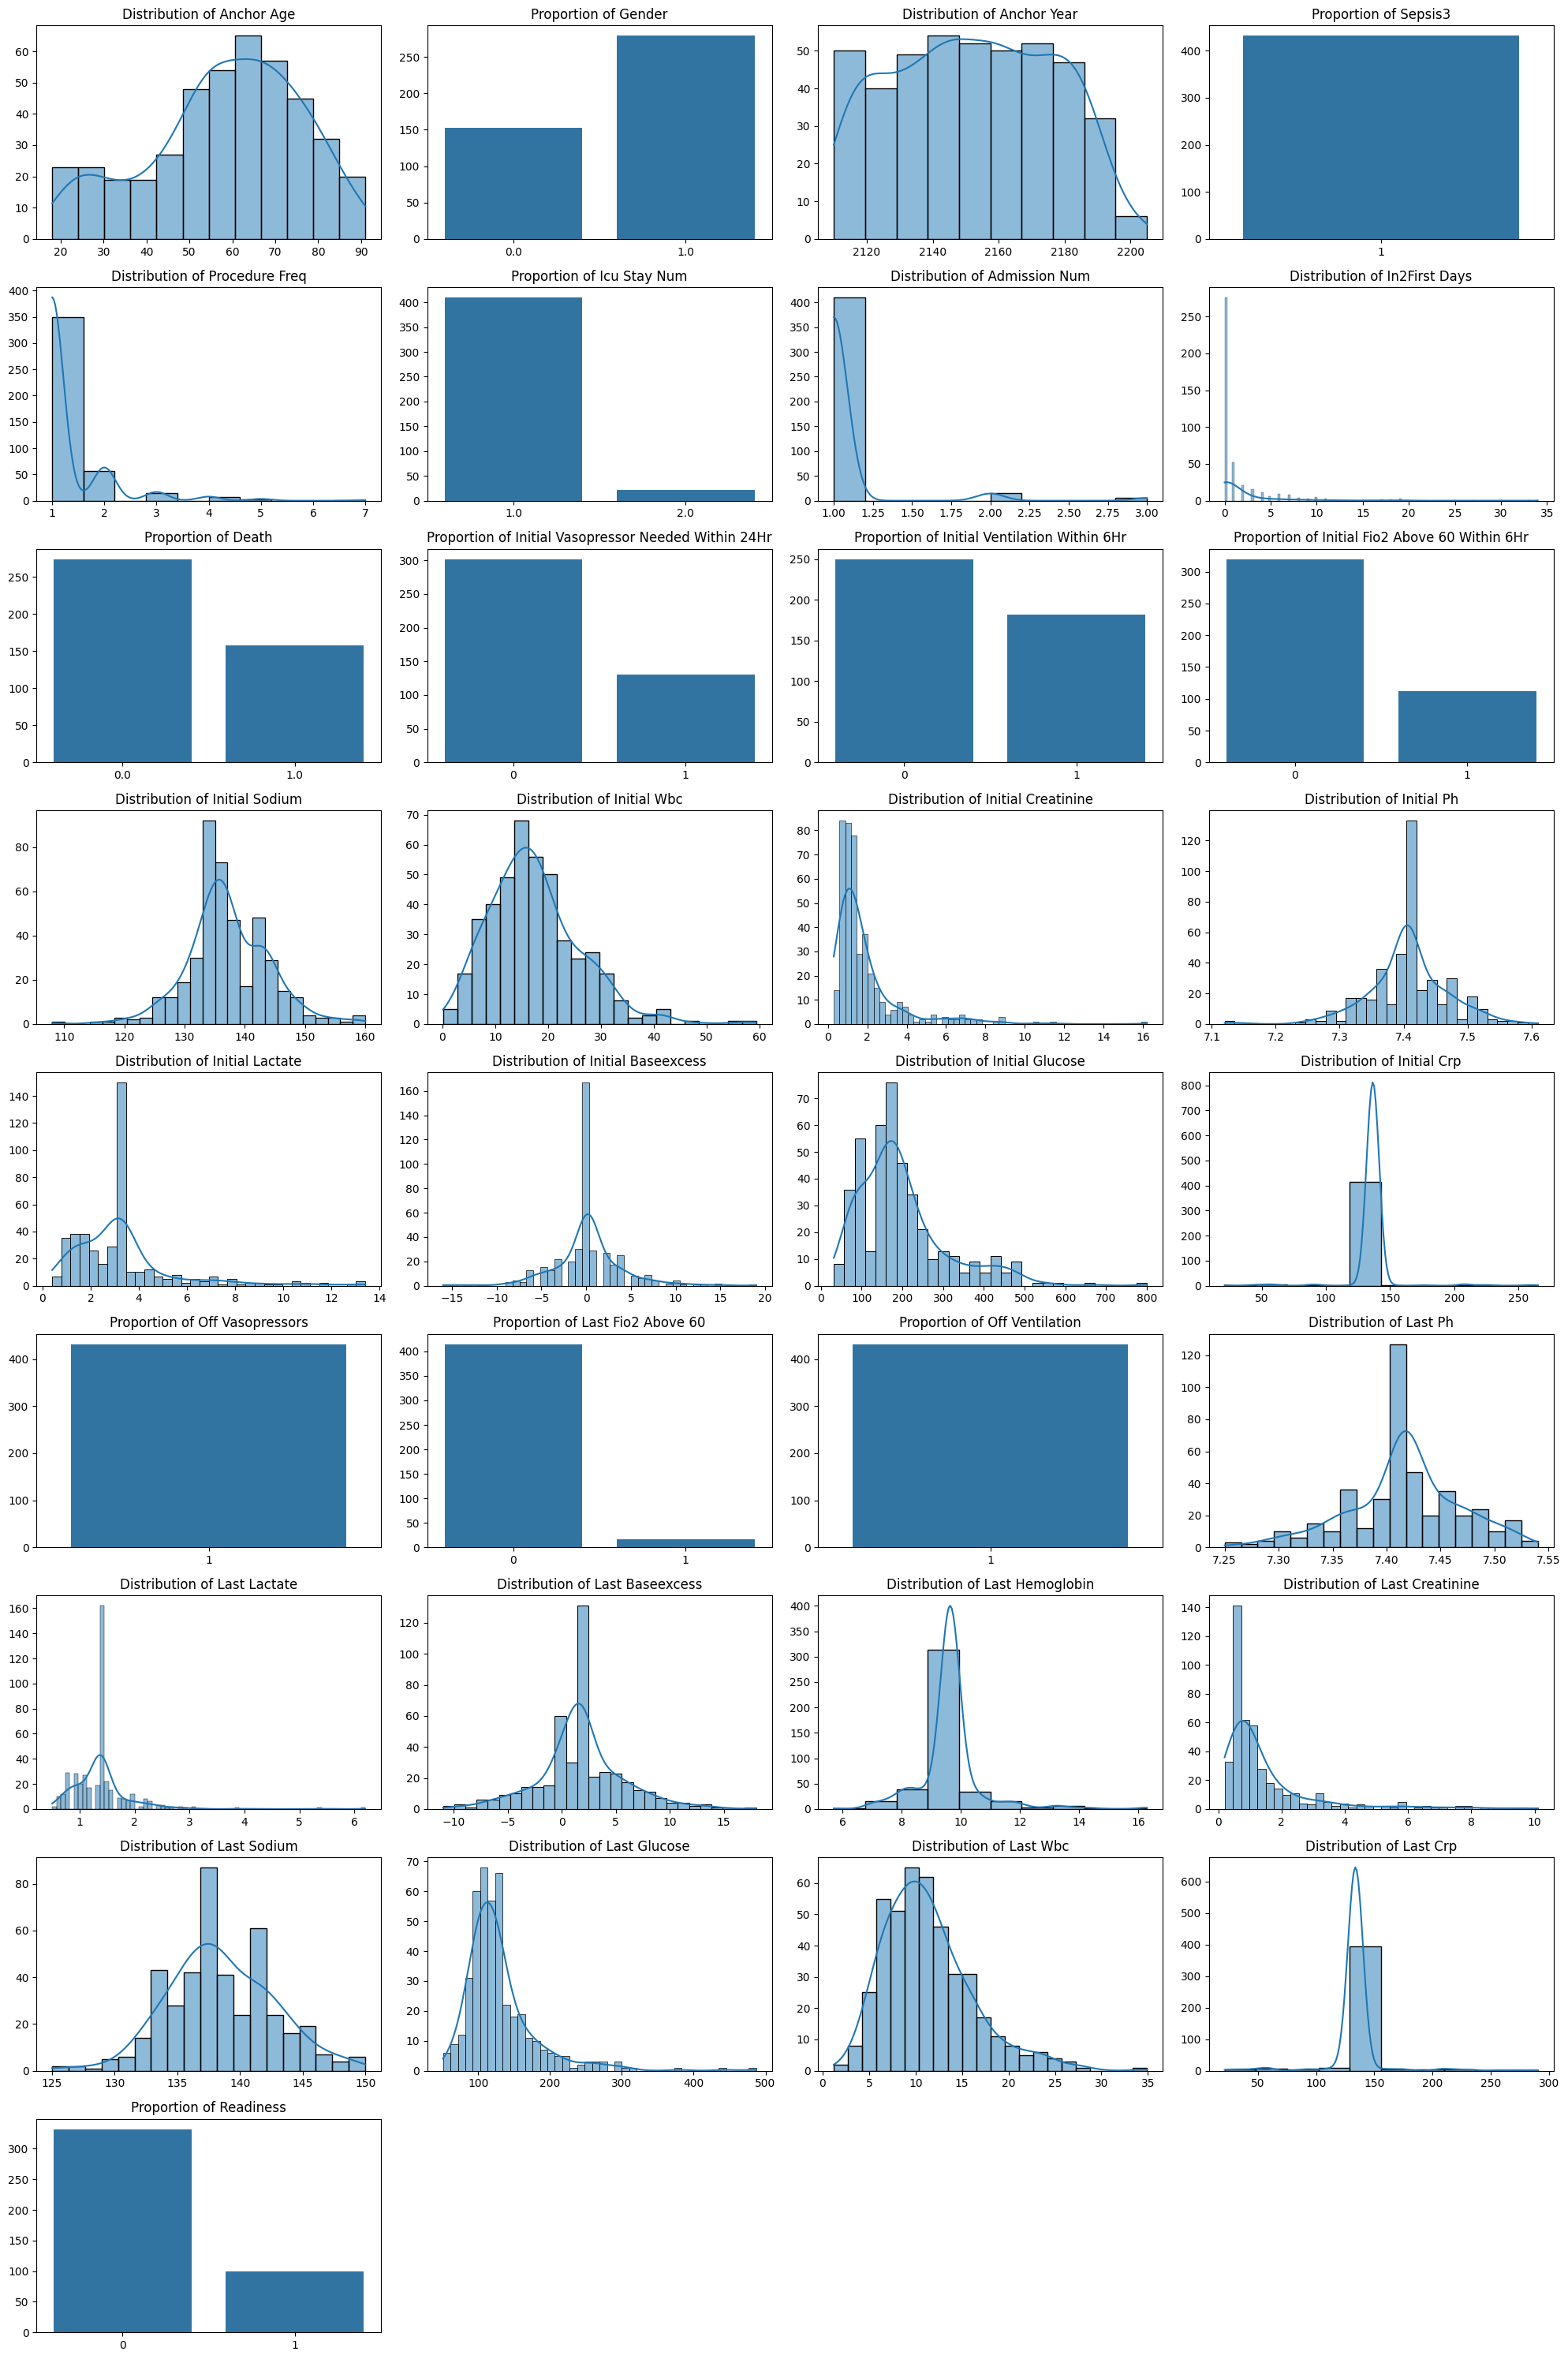

In [80]:
# Initialize figure and axes for subplots
fig, axes = plt.subplots(nrows=len(X.columns) // 4 + 1, ncols=4, figsize=(20, 30))
axes = axes.flatten()

# Plot each variable's distribution or proportion
for i, column in enumerate(X.columns):
    ax = axes[i]
    if X[column].dtype == 'object' or X[column].nunique() <= 2:  # Categorical or binary variable
        sns.countplot(x=column, data=X, ax=ax)
        ax.set_title(f'Proportion of {column.title().replace("_", " ")}')
    else:  # Continuous variable
        sns.histplot(X[column], kde=True, ax=ax)
        ax.set_title(f'Distribution of {column.title().replace("_", " ")}')

    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [105]:
# Use statsmodels to obtain detailed model summary with p-values
# normalize & perform linear regression & print regression output
scaler = MinMaxScaler()

# Fit and transform the scaler on x_train
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_with_intercept = sm.add_constant(X_train_scaled_df)  # Add intercept term for statsmodels
model_sm = sm.OLS(y_train.reset_index(drop=True), X_train_scaled_with_intercept)
results = model_sm.fit()

# Print detailed summary including p-values
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    los   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     17.40
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           4.28e-46
Time:                        18:56:53   Log-Likelihood:                -913.99
No. Observations:                 288   AIC:                             1890.
Df Residuals:                     257   BIC:                             2004.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [106]:
# Extract variable names with p-values < 0.05
significant_variables = []
for i, p_value in enumerate(results.pvalues[1:]):  # Skip the intercept (index 0)
    if p_value < 0.05:
        significant_variables.append(X_train.columns[i])

# Print significant variables
print("Significant Variables (p-value < 0.05):")
print(significant_variables)

Significant Variables (p-value < 0.05):
['sepsis3', 'procedure_freq', 'in2first_days', 'initial_vasopressor_needed_within_24hr', 'initial_sodium', 'initial_creatinine', 'last_baseexcess', 'last_crp']


In [114]:
# normalize & perform linear regression & print regression output
scaler = MinMaxScaler()

# Fit and transform the scaler on x_train
X_train_subset = X_train[significant_variables]
X_train_scaled = scaler.fit_transform(X_train_subset)

# Transform X_test using the same scaler
X_test_subset = X_test[significant_variables]
X_test_scaled = scaler.transform(X_test_subset)

# fit linear model
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'''{'#'*5} Prediction Outcome on Test Data {'#'*5}''')
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


##### Prediction Outcome on Test Data #####
Mean Squared Error (MSE): 28.7395
R-squared (R2): 0.3993


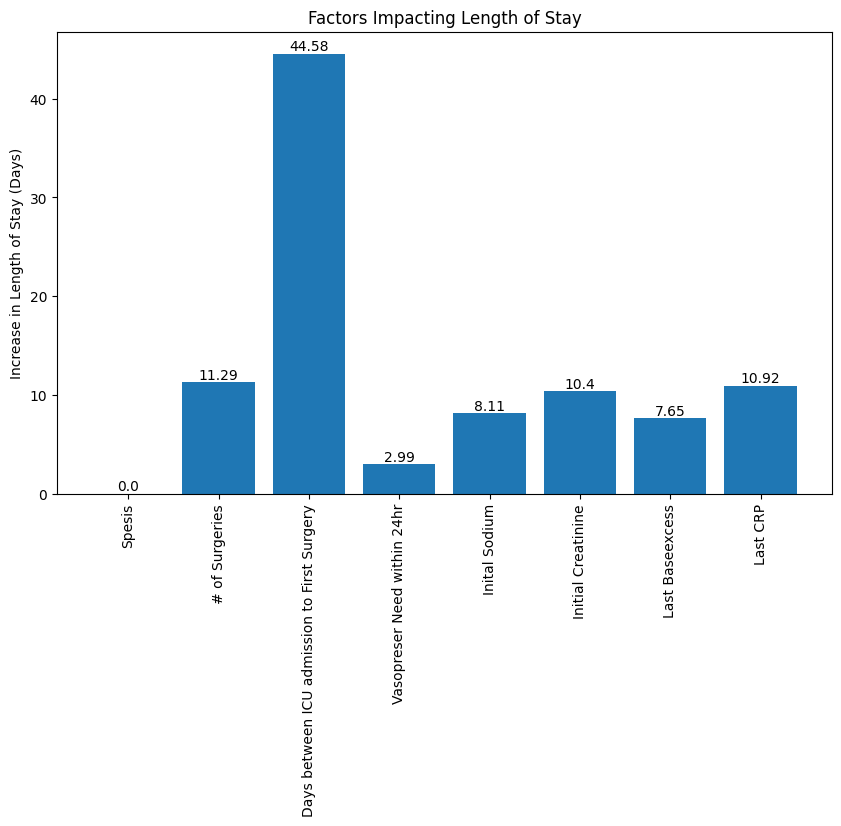

In [125]:
# Get feature names and coefficients
feature_names = X_train.columns
importance = model.coef_

# Plot feature importance (coefficients) with annotations
plt.figure(figsize=(10, 6))
bars = plt.bar([x for x in range(len(importance))], importance)
# plt.xlabel('')
plt.ylabel('Increase in Length of Stay (Days)')
plt.title('Factors Impacting Length of Stay')

# Add annotations with values on top of each bar
for bar, val in zip(bars, importance):
    yval = round(val, 2)  # Round the value for cleaner display
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, str(yval), ha='center', va='bottom')
plt.xticks(np.arange(0, len(X_train_subset.columns), step=1), labels = ['Spesis', '# of Surgeries', 'Days between ICU admission to First Surgery', 'Vasopreser Need within 24hr','Inital Sodium', 'Initial Creatinine','Last Baseexcess', 'Last CRP'], rotation=90)
plt.show()

Sample interpretation: For every additional procudure performed, the patient's length of stay increases by 11.29 days.

# Step 3: Inference